In [1]:
include("../src/CoherentStructures.jl") #this is terrible but neccessary during development (?)

Main.CoherentStructures

In [2]:
using StreamMacros, Main.CoherentStructures
using Tensors, Arpack, Distances
using Plots, UnicodePlots
using DelimitedFiles

In [3]:
# Parameters
grid_resolution        = 1000
quadrature_order       = 1
nevs                   = 20
topk                   = 3
ϵ                      = 0.04
num_steps              = 40
a                      = .98;   # parameter value corresponding to ϵ=0

In [4]:
T(x ,p) = [rem2pi(x[1] + x[2] + (p+a)*sin(x[1]), RoundDown),
           rem2pi(       x[2] + (p+a)*sin(x[1]), RoundDown)]

T (generic function with 1 method)

In [5]:
LL, UR = (0.0, 0.0), (2π, 2π)
ctx, _ = regularTriangularGrid((grid_resolution, grid_resolution), LL, UR, quadrature_order = quadrature_order)
pred(x,y) = peuclidean(x, y, [2π, 2π]) < 1e-9
bdata = BoundaryData(ctx, pred);

In [6]:
M = assembleMassMatrix(ctx, bdata=bdata);

In [7]:
# assemble K
DT₀(x) = linearized_transfer_function_autodiff(y -> T(y,0) , x)
A₀(x) = 0.5*(one(Tensor{2,2}) + dott(inv(DT₀(x))))
@time K = assembleStiffnessMatrix(ctx, A₀, bdata=bdata)
nothing

  9.597307 seconds (201.84 M allocations: 6.787 GiB, 8.58% gc time)


In [8]:
evs = zeros(num_steps+1,nevs)
evs[Int(num_steps/2 +1),:] , _ = eigs(K, M, nev=20, which=:SM);

In [9]:
for i in 1:(num_steps/2)
    DTϵ(x) = linearized_transfer_function_autodiff(y -> T(y,i*ϵ) , x)
    Aϵ(x) = 0.5*(one(Tensor{2,2}) + dott(inv(DTϵ(x))))
    @time Kϵ = assembleStiffnessMatrix(ctx, Aϵ, bdata=bdata)
    DTminusϵ(x) = linearized_transfer_function_autodiff(y -> T(y,-i*ϵ) , x)
    Aminusϵ(x) = 0.5*(one(Tensor{2,2}) + dott(inv(DTminusϵ(x))))
    @time Kminusϵ = assembleStiffnessMatrix(ctx, Aminusϵ, bdata=bdata)
    @time evs[Int(num_steps/2 +1+i),:], _ = eigs(Kϵ, M, nev=nevs, which=:SM)
    @time evs[Int(num_steps/2 +1-i),:], _ = eigs(Kminusϵ, M, nev=nevs, which=:SM)
    print(Int(i), "/" ,Int(num_steps/2), "\n")
end
nothing

  9.251369 seconds (208.30 M allocations: 6.731 GiB, 10.68% gc time)
  9.191076 seconds (208.30 M allocations: 6.731 GiB, 8.69% gc time)
1/20
  8.826485 seconds (207.58 M allocations: 6.696 GiB, 9.86% gc time)
  8.858672 seconds (207.58 M allocations: 6.696 GiB, 9.14% gc time)
2/20
  8.748941 seconds (207.58 M allocations: 6.696 GiB, 9.83% gc time)
  8.809671 seconds (207.58 M allocations: 6.696 GiB, 9.16% gc time)
3/20
  8.640640 seconds (207.58 M allocations: 6.696 GiB, 9.73% gc time)
  8.639667 seconds (207.58 M allocations: 6.696 GiB, 9.10% gc time)
4/20
  8.750528 seconds (207.58 M allocations: 6.696 GiB, 9.76% gc time)
  8.756550 seconds (207.58 M allocations: 6.696 GiB, 9.08% gc time)
5/20
  8.791826 seconds (207.58 M allocations: 6.696 GiB, 10.33% gc time)
  8.654041 seconds (207.58 M allocations: 6.696 GiB, 9.03% gc time)
6/20
  8.718021 seconds (207.58 M allocations: 6.696 GiB, 10.20% gc time)
  8.630848 seconds (207.58 M allocations: 6.696 GiB, 9.11% gc time)
7/20
  8.733504

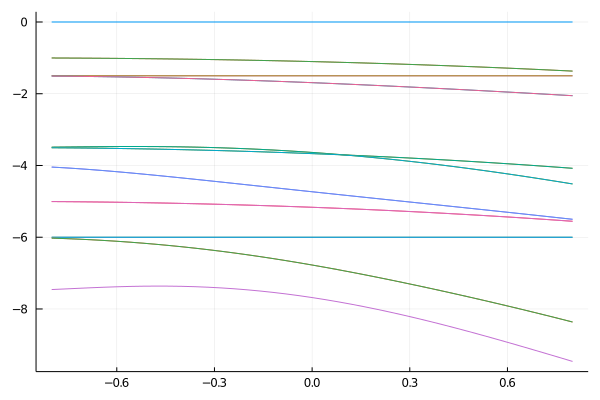

In [10]:
Plots.plot(range(-(num_steps/2)*ϵ,(num_steps/2)*ϵ,length=num_steps+1), evs, legend=false, fmt = :png)

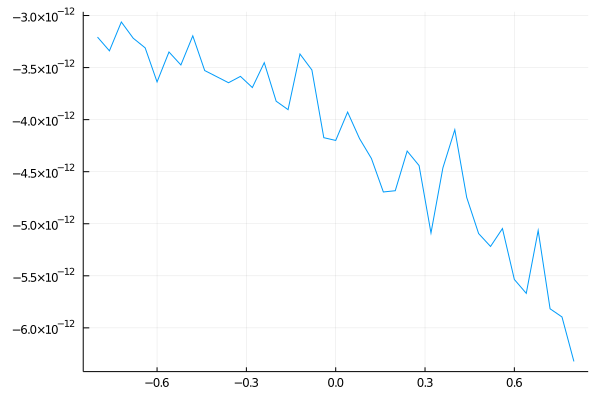

In [11]:
Plots.plot(range(-(num_steps/2)*ϵ,(num_steps/2)*ϵ,length=num_steps+1), evs[:,1], legend=false, fmt = :png)

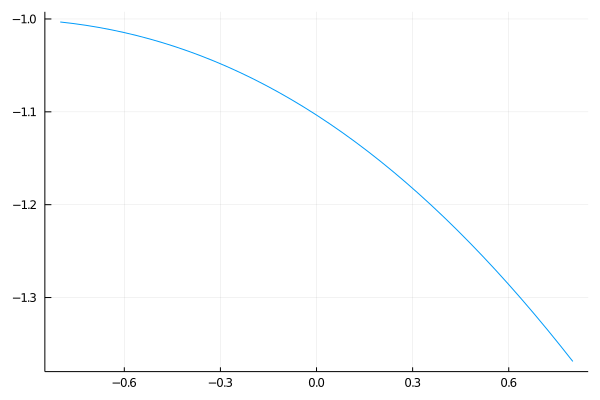

In [12]:
Plots.plot(range(-(num_steps/2)*ϵ,(num_steps/2)*ϵ,length=num_steps+1), evs[:,2], legend=false, fmt = :png)

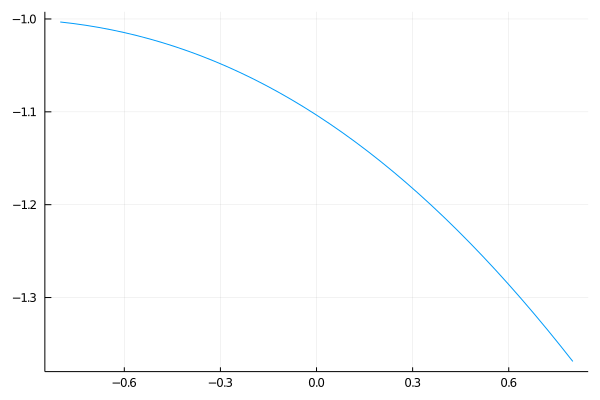

In [13]:
Plots.plot(range(-(num_steps/2)*ϵ,(num_steps/2)*ϵ,length=num_steps+1), evs[:,3], legend=false, fmt = :png)

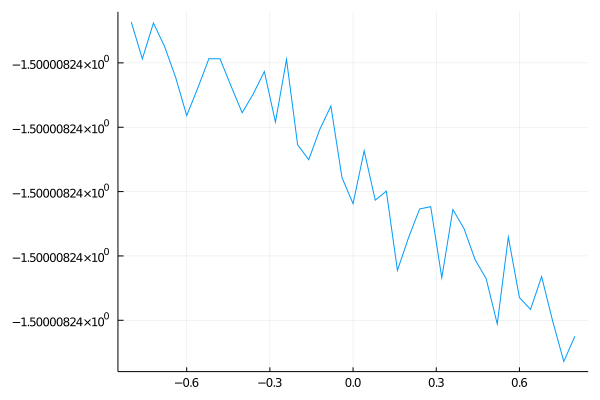

GKS: Possible loss of precision in routine SET_WINDOW


In [14]:
Plots.plot(range(-(num_steps/2)*ϵ,(num_steps/2)*ϵ,length=num_steps+1), evs[:,4], legend=false, fmt = :png)

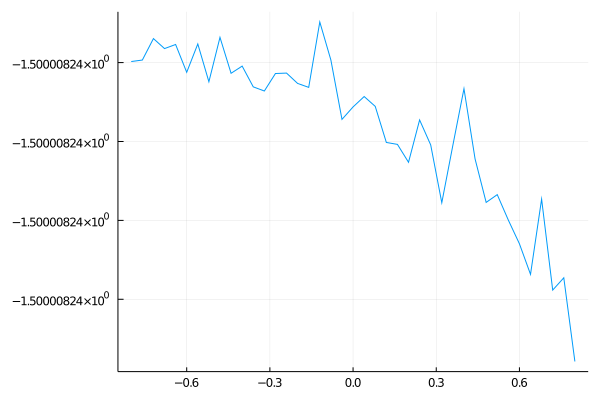

In [15]:
Plots.plot(range(-(num_steps/2)*ϵ,(num_steps/2)*ϵ,length=num_steps+1), evs[:,5], legend=false, fmt = :png)

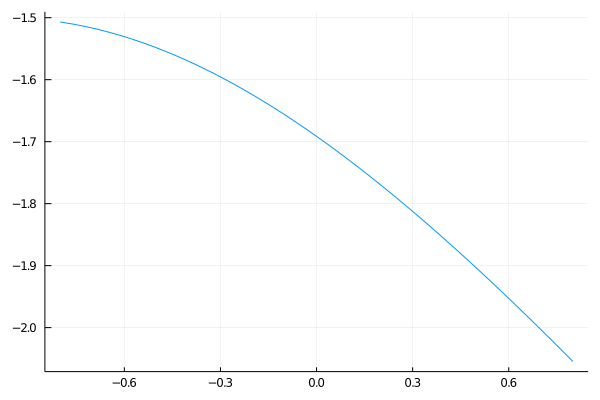

In [16]:
Plots.plot(range(-(num_steps/2)*ϵ,(num_steps/2)*ϵ,length=num_steps+1), evs[:,6], legend=false, fmt = :png)

In [17]:
[range(-(num_steps/2)*ϵ,(num_steps/2)*ϵ,length=num_steps+1)  evs]

41×21 Array{Float64,2}:
 -0.8   -3.20718e-12  -1.00326  -1.00326  …  -6.02497  -6.02497  -7.45846
 -0.76  -3.33919e-12  -1.00487  -1.00487     -6.03731  -6.03731  -7.44199
 -0.72  -3.06208e-12  -1.00681  -1.00681     -6.05218  -6.05218  -7.42512
 -0.68  -3.21821e-12  -1.00909  -1.00909     -6.0696   -6.0696   -7.40885
 -0.64  -3.31049e-12  -1.0117   -1.0117      -6.08961  -6.08961  -7.39404
 -0.6   -3.63747e-12  -1.01466  -1.01466  …  -6.11224  -6.11224  -7.3814
 -0.56  -3.35017e-12  -1.01796  -1.01796     -6.13752  -6.13752  -7.37157
 -0.52  -3.4748e-12   -1.02161  -1.02161     -6.16549  -6.16549  -7.36503
 -0.48  -3.19505e-12  -1.02562  -1.02562     -6.19617  -6.19617  -7.36219
 -0.44  -3.5286e-12   -1.02999  -1.02999     -6.22958  -6.22958  -7.36337
 -0.4   -3.58678e-12  -1.03473  -1.03473  …  -6.26574  -6.26574  -7.36883
 -0.36  -3.64551e-12  -1.03984  -1.03984     -6.30465  -6.30465  -7.37876
 -0.32  -3.58437e-12  -1.04533  -1.04533     -6.34632  -6.34632  -7.3933
  ⋮             

In [18]:
evs

41×20 Array{Float64,2}:
 -3.20718e-12  -1.00326  -1.00326  -1.50001  …  -6.02497  -6.02497  -7.45846
 -3.33919e-12  -1.00487  -1.00487  -1.50001     -6.03731  -6.03731  -7.44199
 -3.06208e-12  -1.00681  -1.00681  -1.50001     -6.05218  -6.05218  -7.42512
 -3.21821e-12  -1.00909  -1.00909  -1.50001     -6.0696   -6.0696   -7.40885
 -3.31049e-12  -1.0117   -1.0117   -1.50001     -6.08961  -6.08961  -7.39404
 -3.63747e-12  -1.01466  -1.01466  -1.50001  …  -6.11224  -6.11224  -7.3814
 -3.35017e-12  -1.01796  -1.01796  -1.50001     -6.13752  -6.13752  -7.37157
 -3.4748e-12   -1.02161  -1.02161  -1.50001     -6.16549  -6.16549  -7.36503
 -3.19505e-12  -1.02562  -1.02562  -1.50001     -6.19617  -6.19617  -7.36219
 -3.5286e-12   -1.02999  -1.02999  -1.50001     -6.22958  -6.22958  -7.36337
 -3.58678e-12  -1.03473  -1.03473  -1.50001  …  -6.26574  -6.26574  -7.36883
 -3.64551e-12  -1.03984  -1.03984  -1.50001     -6.30465  -6.30465  -7.37876
 -3.58437e-12  -1.04533  -1.04533  -1.50001     -6.34

In [19]:
writedlm("D:/"*string(grid_resolution)*"_"*string(Integer(num_steps/2)*ϵ)*".csv", [range(-(num_steps/2)*ϵ,(num_steps/2)*ϵ,length=num_steps+1)  evs], ",")